In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import theano
import matplotlib
from matplotlib import pyplot
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from braindecode.datasets.raw import CleanSignalMatrix
from braindecode.mywyrm.processing import highpass_cnt, resample_cnt, common_average_reference_cnt
from braindecode.datasets.sensor_positions import get_C_sensors_sorted
from braindecode.mywyrm.clean import BBCISetNoCleaner, BBCISetCleaner
from braindecode.datasets.loaders import BBCIDataset
from braindecode.datasets.signal_processor import SignalProcessor

def load_raw_data(filename='data/BBCI-without-last-runs/BhNoMoSc1S001R01_ds10_1-12.BBCI.mat',
                 sensors=['CPz', 'CP1', 'CP2']):
    set_loader = BBCIDataset(filename=filename, load_sensor_names=sensors)
    
    signal_processor = SignalProcessor(set_loader=set_loader,
        cnt_preprocessors=[(highpass_cnt, {'low_cut_off_hz': 0.5})])
    raw_dataset = CleanSignalMatrix(signal_processor=signal_processor,
                                          cleaner=BBCISetNoCleaner(),
                                      sensor_names=None) # sensor_names=None implies all sensors

    raw_dataset.load()
    raw_topo_view = raw_dataset.get_topological_view()
    return raw_topo_view, raw_dataset.y

def load_raw_data_as_thesis(filename='data/BBCI-without-last-runs/BhNoMoSc1S001R01_ds10_1-12.BBCI.mat'):
    
    set_loader = BBCIDataset(filename=filename)
    signal_processor = SignalProcessor(set_loader=set_loader,
         cnt_preprocessors=[(resample_cnt, dict(newfs=150)),
                            (highpass_cnt, {'low_cut_off_hz': 0.5}),
                            (common_average_reference_cnt, dict())])
    raw_dataset = CleanSignalMatrix(signal_processor=signal_processor,
                                          cleaner=BBCISetNoCleaner(),
                                         sensor_names=get_C_sensors_sorted())

    raw_dataset.load()
    raw_topo_view = raw_dataset.get_topological_view()
    
    return raw_topo_view, raw_dataset.y

# Lasagne Movement Decoding Tutorial

This is a tutorial how to construct and train two networks for eeg movement decoding with lasagne:

* a simple model with only three sensors and a single temporal filter
* the raw net model of the master thesis

## Single filter net

Our single filter net only does:

1. temporal filtering
2. squaring
3. sum over entire trial
4. logarithm
5. linear layer, two weights for two classes
6. softmax

First we load some data for only the right and rest class. This is not lasagne-specific.
X will be a 4D tensor: trial x channel x time x empty (no real fourth dimension :))

In [8]:
X, y = load_raw_data(filename='data/BBCI-without-last-runs/MaJaMoSc1S001R01_ds10_1-11.BBCI.mat')
classes = y

right_rest_mask = np.logical_or(classes == 0, classes==2)

X_right_rest = X[right_rest_mask].astype(np.float32)
y_right_rest = y[right_rest_mask].astype(np.int32)
classes_right_rest = classes[right_rest_mask].astype(np.int32)

Next, we construct our network.
The layers are defined in their topological order, you always give the previous layer as the first argument to the next layer. 

In [9]:
import lasagne
import theano.tensor as T
from lasagne.nonlinearities import softmax
from numpy.random import RandomState
# Make sure that everything is reproducible by initializing the random generator
lasagne.random.set_rng(RandomState(23903823)) #23903823 for low freq #4857 for high freq

# Input is 4d, last dimension will be empty in our case.
input_var = T.tensor4('inputs')

# The layers itself:
network = lasagne.layers.InputLayer(shape=[None] + list(X.shape[1:]),
                                    input_var=input_var)
network = lasagne.layers.Conv2DLayer(network, num_filters=1,filter_size=[100, 1], 
                                     nonlinearity=T.sqr)
network = lasagne.layers.GlobalPoolLayer(network, pool_function=T.sum)
network = lasagne.layers.NonlinearityLayer(network, nonlinearity=T.log)
network = lasagne.layers.DenseLayer(network, num_units=2,nonlinearity=softmax)

Some details:

We initialize the random generator just to keep everything reproducible.

We have to specify the size of the input when we construct our network.
The ```None``` 
in 
```python 
shape=[None] + list(X.shape[1:])
```
means we can put any number of trials into the network at once, for example during training.

A practically useful way to pass the previous layer to the next layer this is to always assign each layer to a variable with the same name, e.g., ```network``` below. This saves you from doing some further changes when you add another layer in the middle of the network. For example, if we would like to add a dropout layer between input and first convolution, we could modify it like this:

```python 

network = lasagne.layers.InputLayer(shape=[None] + list(X.shape[1:]),
                                    input_var=input_var)
network = lasagne.layers.DropoutLayer(network, p=0.5)
network = lasagne.layers.Conv2DLayer(network, num_filters=1,filter_size=[100, 1], 
                                     nonlinearity=T.sqr)
                                     ...
```


Now we need to construct the theano computation graphs out of our networks. To get the computation graph for the predictions, lasagne provides the function ```get_output```.

In [10]:
target_var = T.ivector('targets')
prediction = lasagne.layers.get_output(network)

Next, we need to define our loss, in this cas we use categorical cross entropy, which is the typical choice for a softmax output.

$L_t = - \sum_c{target_{t,c} \log(prediction_{t,c})}$

where t is the trial and c is the class (target is 1 for one class and 0 for the others).

In [11]:
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()

Next we create our update function, i.e., given the loss, how should the weights/parameters be updated. In our case, we use adam, which will use the gradients of the loss in the same way as in the master thesis.

In [12]:
# create parameter update expressions
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.001)

The updates variable is a dictionary with an update expression (i.e., how to change the network in one training step, given the training batch) for each parameter of the network.

Now we are ready to compile our theano *computation graphs* into callable functions.
First we just write a function that computes the loss to monitor the training progression.

In [13]:
loss_fn = theano.function([input_var, target_var], loss)

This compilation usually takes quite some time when you call it for the first time and should get faster on subsequent calls due to theano's caching. Next we create a function that will update the parameters. 

In [14]:
train_fn = theano.function([input_var, target_var], updates=updates)

We can now start the training. For simplicity we will always train on the entire training set and only look at the loss on the entire training set.

In [16]:
for epoch in range(301):
    train_fn(X_right_rest, classes_right_rest)
    if epoch % 50 == 0:
        epoch_loss = loss_fn(X_right_rest, classes_right_rest)
        print("Epoch {:d} Loss {:g}".format(epoch, epoch_loss / len(X_right_rest)))

Epoch 0 Loss 0.000889384
Epoch 50 Loss 0.000610989
Epoch 100 Loss 0.000542741
Epoch 150 Loss 0.000527569
Epoch 200 Loss 0.000524368
Epoch 250 Loss 0.000523469
Epoch 300 Loss 0.000522961


We see that the loss steadily goes down. Now let's look at the filter our network has computed. When we created the update expressions, we extracted all parameters of the network into the symbolic theano ```params``` variable.

In [17]:
params

[W, b, W, b]

The parameters are weights of first layer, bias of first layer, weights of softmax layer and bias of softmax layer. We now get the value of the weights of the first layer and plot them. The weights have a length of 200 ms.

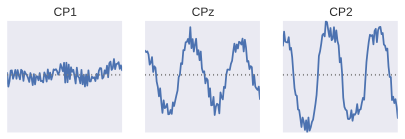

In [18]:
from braindecode.analysis.plot_util import plot_head_signals_tight
plot_head_signals_tight(params[0].get_value().squeeze(),
                       ['CPz', 'CP1', 'CP2'], figsize=(7,2))
None

Indeed, we see a low frequency shape (~12Hz), mostly on the right side. When we look at the softmax layer, this is more indicating the rest class than the right hand (first value, the right hand class value, is more negative), which is plausible.

In [19]:
params[2].get_value()

array([[-0.82026809, -0.81543839]], dtype=float32)

## Raw net model

Let's replicate the raw net model from the thesis. We first load the raw data with the same specifications as in the thesis visualizations, i.e., resample to 150 Hz, highpass above 0.5Hz, common average reference. We also use all four classes. 

In [20]:
X, y = load_raw_data_as_thesis()
classes = y
X = X.astype(np.float32)
classes = classes.astype(np.int32)

The model is now same as in thesis, layerwise with lasagne it is:

1. Move the channel dimension to the last dimension (to still have the original sensor dimension after convolution, i.e. the kernel has size 1 x 15 x 1, not #sensors x 15 x 1)
2. Convolve with a kernel 1 x 15 (time) x 1, i.e., only stretches along time dimension
3. Dropout 
4. Convolve with kernel taking all sensors and all units of previous layer and square the output 
5. Dropout
6. Mean Pool across time, with pool length 50 and pool stride 10
7. Multiply with 50 to get sum pooling
8. Take Logarithm
9. Dropout
10. Fully connected layer with softmax activation

In [21]:
from lasagne.nonlinearities import softmax, identity
from numpy.random import RandomState

lasagne.random.set_rng(RandomState(23903823)) #23903823 for low freq #4857 for high freq

input_var = T.tensor4('inputs')

network = lasagne.layers.InputLayer(shape=[None] + list(X.shape[1:]),
                                    input_var=input_var)
# we have to switch channel dimension to height axis to not squash/convolve them away
network = lasagne.layers.DimshuffleLayer(network, pattern=(0,3,2,1))
network = lasagne.layers.Conv2DLayer(network, num_filters=20,filter_size=[15, 1], nonlinearity=identity)
network = lasagne.layers.DropoutLayer(network, p=0.5)
network = lasagne.layers.Conv2DLayer(network, num_filters=20,filter_size=[1, 45], nonlinearity=T.sqr)
network = lasagne.layers.Pool2DLayer(network, pool_size=(50,1), stride=(10,1), mode='average_exc_pad')
# multiply again with length of pool to get sum from mean
network = lasagne.layers.NonlinearityLayer(network, nonlinearity=lambda x: x * 50)
network = lasagne.layers.NonlinearityLayer(network, nonlinearity=T.log)
network = lasagne.layers.DropoutLayer(network, p=0.5)
network = lasagne.layers.DenseLayer(network, num_units=4,nonlinearity=softmax)

Next is the construction of the theano graphs.
This time, we construct one graph for predictions with dropout (for training) and one without dropout (for testing).
```deterministic=True``` in our case indicates we do not want dropout. Note that in lasagne, if we misspell deterministic, there will be no error! So we have to take care that we spell these keywords correctly.

We also add a norm constraint, that the convolutional weights should have a maximum norm of 2 and the dense layer a maximum norm of 0.5.

In [22]:
target_var = T.ivector('targets')
prediction_with_dropout = lasagne.layers.get_output(network)
prediction_without_dropout = lasagne.layers.get_output(network, deterministic=True)

loss_with_dropout = lasagne.objectives.categorical_crossentropy(prediction_with_dropout, target_var).mean()

loss_without_dropout = lasagne.objectives.categorical_crossentropy(prediction_without_dropout, target_var).mean()
# create parameter update expressions
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.adam(loss_with_dropout, params, learning_rate=0.001)

# Add norm constraints
all_layers = lasagne.layers.get_all_layers(network)
for l in all_layers:
    if isinstance(l, lasagne.layers.Conv2DLayer):
        updates[l.W] = lasagne.updates.norm_constraint(updates[l.W], max_norm=2.0)
    if isinstance(l, lasagne.layers.DenseLayer):
        updates[l.W] = lasagne.updates.norm_constraint(updates[l.W], max_norm=0.5)

Again the construction of the train and loss function, using the loss without dropout to show the progress. We also construct a prediction function to compute accuracies.

In [23]:
# compile training function that updates parameters and returns training loss
train_fn = theano.function([input_var, target_var], updates=updates)
loss_fn = theano.function([input_var, target_var], loss_without_dropout)
pred_fn = theano.function([input_var], prediction_without_dropout)

We will now do a "proper" experiment:

* we split off the last 10% as test fold
* in one epoch, we run over randomly sampled mini-batches of our data until we have used every trial 

In [24]:
num_train_trails = int(len(X) * 0.9)
# Note that in python end index is exclusive
X_train = X[:num_train_trails]
classes_train = classes[:num_train_trails]
X_test = X[num_train_trails:]
classes_test = classes[num_train_trails:]

We only use the scikit-learn KFold object to conveniently create balanced size batches of our training data for one epoch. Do not get confused by the "cross_validation" package :)

In [25]:
from sklearn.cross_validation import KFold


batch_size = 60
# Initialize random generator to always get same mini-batches for several runs of the experiment
rng = RandomState(23982398)
for epoch in range(51):
    # Monitoring/Logging
    if epoch % 10 == 0:
        train_loss = loss_fn(X_train, classes_train)
        train_preds = pred_fn(X_train)
        train_pred_classes = np.argmax(train_preds, axis=1)
        train_acc = (np.sum(train_pred_classes == classes_train) /
            float(len(classes_train)))
        test_loss = loss_fn(X_test, classes_test)
        test_preds = pred_fn(X_test)
        test_pred_classes = np.argmax(test_preds, axis=1)
        test_acc = np.sum(test_pred_classes == classes_test) / float(len(classes_test))
        print("Epoch {:d}".format(epoch))
        print("Train loss      {:f}".format(train_loss / len(X_train)))
        print("Train accuracy  {:.2f}%".format(train_acc * 100))
        print("Test loss       {:f}".format(test_loss / len(X_test)))
        print("Test accuracy   {:.2f}%".format(test_acc * 100))
    # We will use the test folds as our mini-batches,
    # training fold indices are completely ignored here
    folds = KFold(len(X_train), n_folds=len(X_train) // batch_size, 
                  shuffle=True, random_state=rng)
    # Actual training, go through entire set
    for _, batch_ind in folds:
        train_fn(X_train[batch_ind], classes_train[batch_ind])
    

Epoch 0
Train loss      0.018755
Train accuracy  25.03%
Test loss       0.173184
Test accuracy   24.44%
Epoch 10
Train loss      0.000754
Train accuracy  77.32%
Test loss       0.007188
Test accuracy   64.44%
Epoch 20
Train loss      0.000397
Train accuracy  85.75%
Test loss       0.003399
Test accuracy   86.67%
Epoch 30
Train loss      0.000231
Train accuracy  91.95%
Test loss       0.001862
Test accuracy   96.67%
Epoch 40
Train loss      0.000117
Train accuracy  97.77%
Test loss       0.001273
Test accuracy   96.67%
Epoch 50
Train loss      0.000090
Train accuracy  98.14%
Test loss       0.001139
Test accuracy   96.67%


We want to see the weights before the squaring, so same as in the master thesis, we combine them to get spatio-temporal weights.

In [29]:
# Combine the weights. We have to reverse them with ::-1 to change convolution to cross-correlation
temporal_weights = params[0].get_value()[:,:,::-1,::-1]
spat_filt_weights = params[2].get_value()[:,:,::-1,::-1]

combined_weights = np.tensordot(spat_filt_weights, temporal_weights, axes=(1,0))

combined_weights = combined_weights.squeeze()

In [30]:
# Lets find the weights that have the largest absolute sum of weights in the softmax layer
soft_weights = params[4].get_value()
soft_weights_topo = soft_weights.reshape(network.input_layer.input_shape[1], 
                                         network.input_layer.input_shape[2],
                                         network.input_layer.input_shape[3],
                                         4)
soft_sum =np.sum(np.abs(soft_weights_topo), axis=(1,2,3))
important_weights = np.argsort(soft_sum)[::-1]

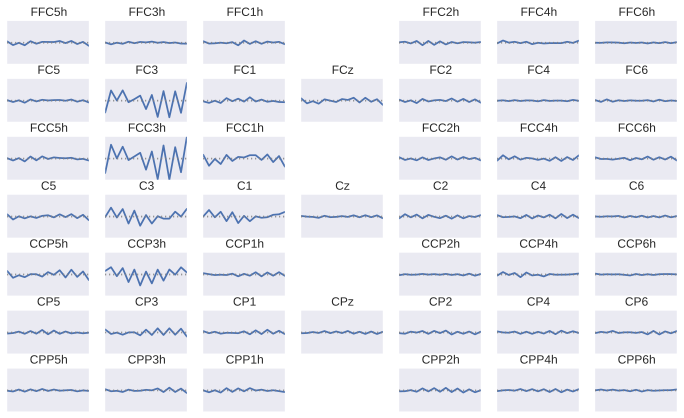

In [31]:
from braindecode.analysis.plot_util import plot_head_signals_tight
plot_head_signals_tight(combined_weights[important_weights[0]], get_C_sensors_sorted())
None

We see a very strong lateralization. We could now go on to further explore for which class this weight is weighted positively etc...

## Appendix

If we want to insepct a theano computation graph, we can print it. This is the graph of the simple model. You can see the the different operations in the graph, i.e. ConvOp, Elemwise sqr/log, or Softmax. 

In [24]:
import theano

theano.printing.debugprint(loss)

Elemwise{true_div,no_inplace} [@A] 'mean'   
 |Sum{acc_dtype=float64} [@B] ''   
 | |CrossentropyCategorical1Hot [@C] ''   
 |   |Softmax [@D] ''   
 |   | |Elemwise{add,no_inplace} [@E] ''   
 |   |   |dot [@F] ''   
 |   |   | |Elemwise{log,no_inplace} [@G] ''   
 |   |   | | |Sum{axis=[2], acc_dtype=float64} [@H] ''   
 |   |   | |   |Flatten{3} [@I] ''   
 |   |   | |     |Elemwise{sqr,no_inplace} [@J] ''   
 |   |   | |       |Elemwise{add,no_inplace} [@K] ''   
 |   |   | |         |ConvOp{('imshp', (3, 2000, 1)),('kshp', (100, 1)),('nkern', 1),('bsize', None),('dx', 1),('dy', 1),('out_mode', 'valid'),('unroll_batch', None),('unroll_kern', None),('unroll_patch', True),('imshp_logical', (3, 2000, 1)),('kshp_logical', (100, 1)),('kshp_logical_top_aligned', True)} [@L] ''   
 |   |   | |         | |inputs [@M]
 |   |   | |         | |HostFromGpu [@N] ''   
 |   |   | |         |   |W [@O]
 |   |   | |         |DimShuffle{x,0,x,x} [@P] ''   
 |   |   | |           |HostFromGpu [@Q] '

## Stuff just for me (Robin) :)

In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'